In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download("all")
#Upgrade Pandas 
# !pip install --upgrade pandas
# !pip install pyLDAvis
# !pip install openpyxl --upgrade --pre
#Mallet's Version of Topic Modelling 
# !pip install --upgrade gensim==3.8
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#python3 -m spacy download en

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import openpyxl 

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Pac

[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package mte_teip5 to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package mte_teip5 is already up-to-date!
[nltk_data]    | Downloading package mwa_ppdb to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package mwa_ppdb is already up-to-date!
[nltk_data]    | Downloading package names to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Downloading package nombank.1.0 to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package nombank.1.0 is already up-to-date!
[nltk_data]    | Downloading package nonbreaking_prefixes to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package nonbreaking_prefixes is already up-to-date!
[nltk_data]    | Downloading package nps_chat to
[

[nltk_data]    |   Package treebank is already up-to-date!
[nltk_data]    | Downloading package twitter_samples to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package twitter_samples is already up-to-date!
[nltk_data]    | Downloading package udhr to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package udhr is already up-to-date!
[nltk_data]    | Downloading package udhr2 to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package udhr2 is already up-to-date!
[nltk_data]    | Downloading package unicode_samples to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package unicode_samples is already up-to-date!
[nltk_data]    | Downloading package universal_tagset to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package universal_tagset is already up-to-date!
[nltk_data]    | Downloading package universal_tree

In [3]:
df = pd.read_excel("model_data_v1.xlsx")
df = df.drop("Unnamed: 0", axis=1)
df.dropna(inplace=True)

In [4]:
#Convert List into bag of words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['text']))

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=30) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=30)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initiate spacy for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [9]:
# Create Dictionary
# id2word = corpora.Dictionary(data_lemmatized)
id2word = corpora.Dictionary(data_words_bigrams)
# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [10]:
import os       #importing os to set environment variable
from gensim.models.wrappers import LdaMallet

os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})
mallet_path = r'C:\new_mallet\mallet-2.0.8\bin\mallet'

ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [12]:
from pprint import pprint
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('anniversary', 0.08830409356725147),
   ('work', 0.0810916179337232),
   ('highly_recommend', 0.05224171539961014),
   ('communication', 0.040740740740740744),
   ('excellent', 0.035282651072124756),
   ('turn', 0.03352826510721248),
   ('wife', 0.03352826510721248),
   ('year', 0.03333333333333333),
   ('piece', 0.028460038986354776),
   ('personalization', 0.023781676413255362)]),
 (1,
  [('nice', 0.11882535978218592),
   ('good', 0.117658498638662),
   ('expect', 0.061843640606767794),
   ('lovely', 0.046868922598210815),
   ('color', 0.043173862310385065),
   ('size', 0.035978218591987556),
   ('feel', 0.027421236872812137),
   ('packaging', 0.022364838584208478),
   ('price', 0.020809023726176584),
   ('soft', 0.019836639439906652)]),
 (2,
  [('give', 0.053388867853085956),
   ('bracelet', 0.047519878833775085),
   ('picture', 0.044301400984475575),
   ('fit', 0.030480878455130634),
   ('photo', 0.025937145020825444),
   ('unique', 0.019121544869367665),
   ('perfectly', 

In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=40, step=6)

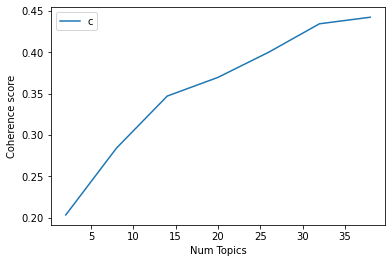

Num Topics = 2  has Coherence Value of 0.2034
Num Topics = 8  has Coherence Value of 0.2841
Num Topics = 14  has Coherence Value of 0.3469
Num Topics = 20  has Coherence Value of 0.3695
Num Topics = 26  has Coherence Value of 0.3999
Num Topics = 32  has Coherence Value of 0.4342
Num Topics = 38  has Coherence Value of 0.4421


In [16]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
coherence_score_dict = {}
for m, cv in zip(x, coherence_values):
    coherence_score_dict[m] = round(cv, 4)
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [17]:
def calculate_optimal_coherence(dict_cv):
    cv = 0
    current_cv = dict_cv[2]
    prev_cv = dict_cv[2]
    diff = 0
    #check for drop
    count = 0
    for key, val in dict_cv.items():
        current_cv = val
        current_diff = current_cv - prev_cv
        current_diff = abs(current_diff)
        if current_cv<prev_cv:
            return count
        elif current_diff>diff:
            diff = current_diff
        else:
            if current_diff < diff:
                return count-1
        prev_cv  = current_cv
        count+=1


In [18]:
optimal = calculate_optimal_coherence(coherence_score_dict)

# Select the model and print the topics
optimal_model = model_list[optimal]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.109*"fast" + 0.093*"shipping" + 0.081*"time" + 0.075*"arrive" + '
  '0.053*"quick" + 0.052*"super" + 0.034*"expect" + 0.032*"shop" + '
  '0.028*"amaze" + 0.021*"wait_give"'),
 (1,
  '0.106*"absolutely" + 0.085*"purchase" + 0.070*"anniversary" + '
  '0.042*"craftsmanship" + 0.038*"happy" + 0.034*"turn" + 0.032*"wonderful" + '
  '0.029*"year" + 0.027*"wife" + 0.026*"soft"'),
 (2,
  '0.096*"nice" + 0.095*"good" + 0.050*"recommend" + 0.027*"wait" + '
  '0.026*"size" + 0.023*"engraving" + 0.023*"son" + 0.022*"feel" + '
  '0.021*"smell" + 0.019*"inside"'),
 (3,
  '0.076*"buy" + 0.072*"boyfriend" + 0.060*"christmas" + 0.043*"give" + '
  '0.035*"color" + 0.030*"present" + 0.019*"bought" + 0.019*"friend" + '
  '0.018*"extremely" + 0.015*"lot"'),
 (4,
  '0.128*"order" + 0.090*"item" + 0.077*"seller" + 0.054*"receive" + '
  '0.034*"day" + 0.023*"send" + 0.018*"helpful" + 0.017*"back" + '
  '0.014*"package" + 0.013*"request"'),
 (5,
  '0.129*"wallet" + 0.037*"picture" + 0.025*"fit" + 0.0

In [19]:
def mallet_to_lda(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    
    model_gensim.sync_state()
    model_gensim.state.sstats = mallet_model.wordtopics
    return model_gensim

In [20]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(mallet_to_lda(ldamallet), corpus, id2word)
vis

C:\Users\User\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.018623 -0.258636       1        1  10.037278
5     -0.216092  0.041993       2        1  10.035069
8      0.220307  0.163501       3        1  10.012730
0      0.031230  0.255670       4        1  10.000348
2      0.002140 -0.006168       5        1   9.997037
6     -0.083471  0.152609       6        1   9.996192
4     -0.064611 -0.007227       7        1   9.992688
3     -0.267083 -0.057283       8        1   9.985463
9      0.264161 -0.036386       9        1   9.973575
7      0.094798 -0.248074      10        1   9.969620, topic_info=           Term         Freq        Total Category  logprob  loglift
317      wallet  1064.000000  1064.000000  Default  30.0000  30.0000
19        order  1114.000000  1114.000000  Default  29.0000  29.0000
287         bag  1022.000000  1022.000000  Default  28.0000  28.0000
61         fast   906.000000   906.000000  Default  27.0000  27.0000
78   absolutely   887.000000   887.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
10       friend   146.258880   186.084461  Topic10  -3.8007   2.0648
241       small   115.998422   183.892057  Topic10  -4.0325   1.8449
115        soft    78.172850   208.836072  Topic10  -4.4272   1.3230
189   christmas    90.781374   493.464996  Topic10  -4.2776   0.6126
546        stun    41.608130    55.680257  Topic10  -5.0578   2.0143

[596 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
911       9  0.777216      abrupt
207       3  1.027112    absolute
78        9  1.000243  absolutely
537       4  1.005026    accurate
0         5  1.006393         add
...     ...       ...         ...
767       2  0.998822       wrong
124       4  0.915407        year
124       6  0.075239        year
124      10  0.012540        year
671       5  1.002286      zipper

[683 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 9, 1, 3, 7, 5, 4, 10, 8])

In [23]:
def format_topics_sentences(ldamodel=mallet_to_lda(ldamallet), corpus=corpus, texts=df):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts['text'])
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.1587,"buy, boyfriend, christmas, give, color, presen...",happy ordered keychain arrive early patiently ...
1,1,4.0,0.2380,"order, item, seller, receive, day, send, helpf...",amazing keychain much quantity amazing custome...
2,2,4.0,0.1422,"order, item, seller, receive, day, send, helpf...",item everything want
3,3,6.0,0.1422,"product, amazing, work, excellent, high, brace...",high
4,4,0.0,0.1682,"fast, shipping, time, arrive, quick, super, ex...",fast shipping beyond thrill come anniversary p...
5,5,1.0,0.1422,"absolutely, purchase, anniversary, craftsmansh...",anniversary
6,6,2.0,0.2033,"nice, good, recommend, wait, size, engraving, ...",photo printing pibb metal plate come good expe...
7,7,4.0,0.1844,"order, item, seller, receive, day, send, helpf...",able figure item transit arrive plenty time sp...
8,8,4.0,0.1680,"order, item, seller, receive, day, send, helpf...",product even imagine come want seller super co...
9,9,1.0,0.1595,"absolutely, purchase, anniversary, craftsmansh...",perhaps could add tag second picture child cou...
